In [70]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Objective function to minimize 

objective_function_name = input("Enter the objective function name (sphere, rosenbrock, ackley, schwefel, rastrigin): ")  # Choose the objective function to minimize

if objective_function_name == 'schwefel':
    lower_bound = -500
    upper_bound = 500
elif objective_function_name == 'rastrigin':
    lower_bound = -5.12
    upper_bound = 5.12
else:
    lower_bound = -10
    upper_bound = 10

def objective_function(x, function_name):
    if function_name == 'sphere':
        return sphere_function(x)
    elif function_name == 'rosenbrock':
        return rosenbrock_function(x)
    elif function_name == 'ackley':
        return ackley_function(x)
    elif function_name == 'schwefel':
        return schwefel_function(x)
    elif function_name == 'rastrigin':
        return rastrigin_function(x)
    else:
        raise ValueError("Unknown function name")

def sphere_function(x):
    return np.sum(x**2) 

def rosenbrock_function(x):
    return sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

def ackley_function(x):
    first_sum = np.sum(x**2)
    second_sum = np.sum(np.cos(2 * np.pi * x))
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(first_sum / n)) - np.exp(second_sum / n) + 20 + np.e

def rastrigin_function(x):
    # Domain: [-5.12, 5.12] typically
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

def schwefel_function(x):
    # Domain: [-500, 500] typically. Global min at [420.9687, ...] -> f(x)=0
    return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))

In [71]:
# Parameter settings for a Particle Swarm Optimization (PSO) algorithm
bounds = np.array([[lower_bound, lower_bound, lower_bound],
                    [upper_bound, upper_bound, upper_bound]]) # Search space boundaries for each dimension

num_particles = 30
max_iterations = 1000
c1, c2 = 0.5, 1.5 # Cognitive and social coefficients
w_inertia = 0.9 # Inertia weight to balance exploration and exploitation

particles = np.random.uniform(bounds[0], bounds[1], (num_particles, 3)) # Initial positions of particles
domain_range = upper_bound - lower_bound # Range of the domain for scaling velocity initialization 
velocities = np.random.uniform(-domain_range*0.1, domain_range*0.1, (num_particles, 3)) # Initial velocities of particles

# Initialize personal best positions and costs
personal_best_positions = np.copy(particles)
personal_best_costs = np.array([objective_function(p, objective_function_name) for p in particles])

# Initialize global best position and cost
global_best_position = particles[0].copy()
global_best_cost = personal_best_costs[0]

Converged after 62 iterations.
Swarm radius: 0.000870 < epsilon (0.001)
Total execution time: 0.03 seconds


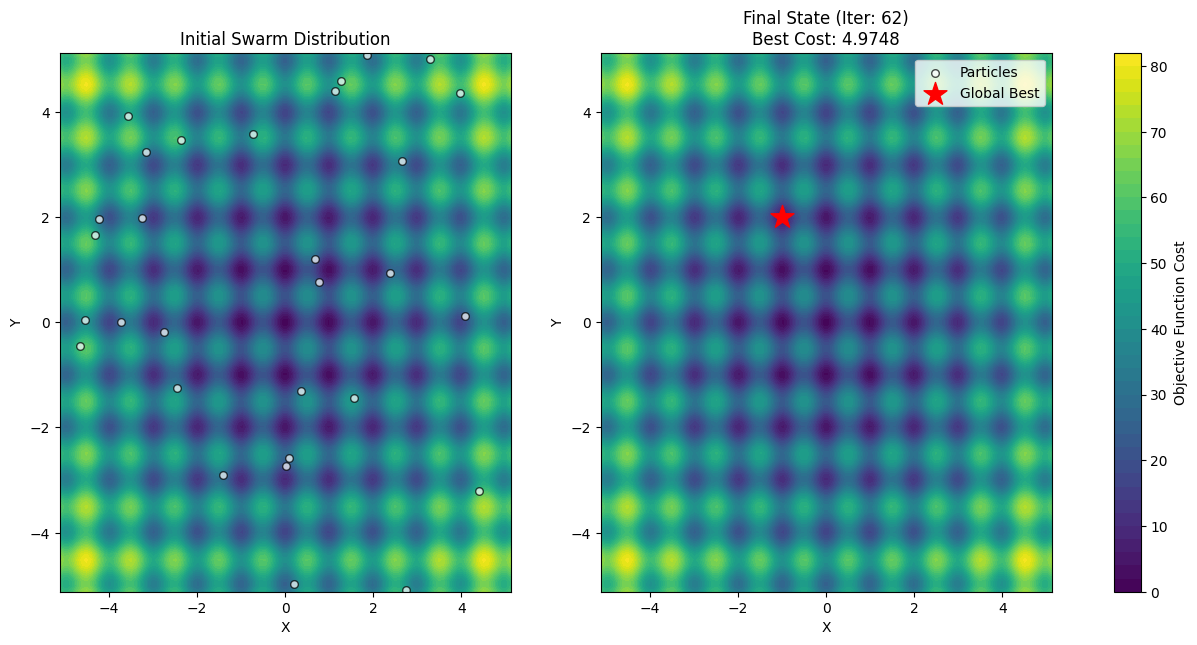

In [72]:
# Perform the optimization loop

def pso_optimization():
    global global_best_position, global_best_cost, velocities, particles, w_inertia

    epsilon = 1e-3 # Convergence threshold

    for iteration in range(max_iterations):
        # Random matrix used to compute the cognitive and social components of the velocity update
        r1, r2 = np.random.rand(num_particles, 3), np.random.rand(num_particles, 3)

        cognitive_component = c1 * r1 * (personal_best_positions - particles)
        social_component = c2 * r2 * (global_best_position - particles)

        velocities = (w_inertia * velocities) + cognitive_component + social_component
        particles += velocities

        # Ensure particles stay within bounds
        particles = np.clip(particles, bounds[0], bounds[1])

        # Evaluate the objective function for all particles
        costs = np.array([objective_function(p, objective_function_name) for p in particles])

        # Update personal bests with numPy boolean indexing
        is_best = costs < personal_best_costs
        personal_best_positions[is_best] = particles[is_best]
        personal_best_costs[is_best] = costs[is_best]

        # Update global best with numPy boolean indexing
        global_best_index = np.argmin(personal_best_costs)
        if personal_best_costs[global_best_index] < global_best_cost:
            global_best_cost = personal_best_costs[global_best_index]
            global_best_position = personal_best_positions[global_best_index]

        w_inertia = np.maximum(0, w_inertia*0.99) # Decrease inertia weight over time

        baricenter = np.mean(particles, axis=0)
        swarm_radius = np.mean(np.linalg.norm(particles - baricenter, axis=1)) # Axis=1 for row-wise norm
        if swarm_radius < epsilon:
            print(f"Converged after {iteration} iterations.")
            print(f"Swarm radius: {swarm_radius:.6f} < epsilon ({epsilon})")
            return iteration

# Dynamic resolution for plotting based on the range
range_width = upper_bound - lower_bound
density = 10 # Points per unit range
min_points = 100
max_points = 400 
num_points = int(min(max(min_points, range_width * density), max_points))

x = np.linspace(lower_bound, upper_bound, num_points)
y = np.linspace(lower_bound, upper_bound, num_points)
X, Y = np.meshgrid(x, y)

Z = np.array([[objective_function(np.array([i, j, 0]), objective_function_name) for i in x] for j in y])

initial_particles = particles.copy() # Initial state for later comparison

# Run the PSO optimization and measure execution time
total_execution_time = time.time()
tot_iterations = pso_optimization()
total_execution_time = time.time() - total_execution_time
print(f"Total execution time: {total_execution_time:.2f} seconds")

def plot_pso_state(ax, particle_data, title, show_best=False):
    # Background contour plot of the objective function
    contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    
    # Draw all particles
    ax.scatter(particle_data[:, 0], particle_data[:, 1], c='white', edgecolors='black', s=30, alpha=0.7, label='Particles')
    
    # If requested, highlight the Global Best (only in the final plot)
    if show_best:
        ax.scatter(global_best_position[0], global_best_position[1], 
                   c='red', marker='*', s=300, label='Global Best') # s=300 is the size of the star
        ax.legend()
        
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    return contour

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

plot_pso_state(ax1, initial_particles, "Initial Swarm Distribution")

contour = plot_pso_state(ax2, particles, f"Final State (Iter: {tot_iterations if tot_iterations is not None else max_iterations})\nBest Cost: {global_best_cost:.4f}", show_best=True)

fig.colorbar(contour, ax=[ax1, ax2], label='Objective Function Cost')

plt.show()